In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import keras.backend as K

In [2]:
train_dir = r'D:\Download\zyFile\Machine_Vision\MV_Seminar_Week 2\Machine_Vision_homework\MV_Seminar Week 5\data_mv\train'
test_dir = r'D:\Download\zyFile\Machine_Vision\MV_Seminar_Week 2\Machine_Vision_homework\MV_Seminar Week 5\data_mv\test'

In [3]:
# Load and preprocess the training data
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',  # Assuming labels are provided as integers
    color_mode='rgb'  # Assuming images are grayscale
)

Found 48 images belonging to 3 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 24 images belonging to 3 classes.


In [5]:
x_train, y_train = train_generator.next()
x_test, y_test = test_generator.next()

# Building Inception Module from Sratch

In [6]:
# Defind the inception module (Module A)

def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    
    return branch_output



Let's break down the lines of code for the Inception module (Module A):

```python
# Defind the inception module (Module A)
def inception_block(input_shape, filter_1x1):
    
    # First branch
    branch_1_conv_1x1 = Conv2D(128, (1,1), padding='same', activation='relu')(input_shape)

    # Second branch
    branch_2_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_2_conv_3x3 = Conv2D(192, (3,3), padding='same', activation='relu')(branch_2_conv_1x1)
    branch_2_conv_1x1 = Conv2D(filter_1x1, (1,1), padding='same', activation='relu')(branch_2_conv_3x3)

    # Third branch
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_shape)
    branch_3_conv_5x5 = Conv2D(96, (5,5), padding='same', activation='relu')(branch_3_conv_1x1 )
    branch_3_conv_1x1 = Conv2D(64, (1,1), padding='same', activation='relu')(branch_3_conv_5x5)

    branch_output = concatenate([branch_1_conv_1x1, branch_2_conv_1x1, branch_3_conv_1x1], axis=-1)
    
    return branch_output
```

### Explanation:

1. **First Branch (`branch_1_conv_1x1`):**
   - `branch_1_conv_1x1` is a 1x1 convolution with 128 filters applied to the input shape.
   - The convolution is followed by batch normalization and a ReLU activation function.

2. **Second Branch (`branch_2_conv_1x1`, `branch_2_conv_3x3`, `branch_2_conv_1x1`):**
   - `branch_2_conv_1x1` is a 1x1 convolution with 64 filters applied to the input shape.
   - `branch_2_conv_3x3` is a 3x3 convolution with 192 filters applied to the output of the previous 1x1 convolution.
   - `branch_2_conv_1x1` is another 1x1 convolution with `filter_1x1` filters applied to the output of the 3x3 convolution.
   - Each convolution is followed by batch normalization and a ReLU activation function.

3. **Third Branch (`branch_3_conv_1x1`, `branch_3_conv_5x5`, `branch_3_conv_1x1`):**
   - `branch_3_conv_1x1` is a 1x1 convolution with 64 filters applied to the input shape.
   - `branch_3_conv_5x5` is a 5x5 convolution with 96 filters applied to the output of the previous 1x1 convolution.
   - `branch_3_conv_1x1` is another 1x1 convolution with 64 filters applied to the output of the 5x5 convolution.
   - Each convolution is followed by batch normalization and a ReLU activation function.

4. **Concatenate Branch Outputs (`branch_output`):**
   - The outputs of the three branches (`branch_1_conv_1x1`, `branch_2_conv_1x1`, `branch_3_conv_1x1`) are concatenated along the last axis (axis=-1).
   - The concatenation creates the final output of the Inception module, combining features extracted by different convolutional filters.

5. **Return (`return branch_output`):**
   - The concatenated output is returned from the function.

In summary, this Inception module creates a complex set of features by applying different convolutional filters with varying kernel sizes (1x1, 3x3, 5x5) to the input shape. The concatenated output captures diverse information, enhancing the representational power of the model.

In [7]:
input_shape = Input(shape=(128,128,3))

In [8]:
x = Conv2D(64, (7,7), activation='relu')(input_shape)
x = MaxPooling2D(2,2)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(32, (1,1), activation='relu')(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = inception_block(x, 64)
x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)


In [9]:
model_1 = Model(inputs=input_shape, outputs=output)

In [10]:
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 122, 122, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 61, 61, 64)   0           ['conv2d[0][0]']                 
                                                                                              

In [11]:
# Compile the model
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model_1.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 26s 26s/step - loss: 1.0938 - accuracy: 0.4167 - val_loss: 1.1817 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 90ms/step - loss: 1.0664 - accuracy: 0.4167 - val_loss: 1.6152 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 93ms/step - loss: 1.1406 - accuracy: 0.4167 - val_loss: 1.1709 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 89ms/step - loss: 1.0618 - accuracy: 0.4167 - val_loss: 1.0923 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 91ms/step - loss: 1.0740 - accuracy: 0.5000 - val_loss: 1.0974 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 90ms/step - loss: 1.0763 - accuracy: 0.5000 - val_loss: 1.1190 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 90ms/step - loss: 1.0752 - accuracy: 0.4167 - val_loss: 1.1217 - val_accuracy: 0.0000e+00

In [13]:
# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

1/1 [==============================] - 1s 570ms/step - loss: 1.0785 - accuracy: 0.5625
Test accuracy: 0.5625
Test loss: 1.0785197019577026


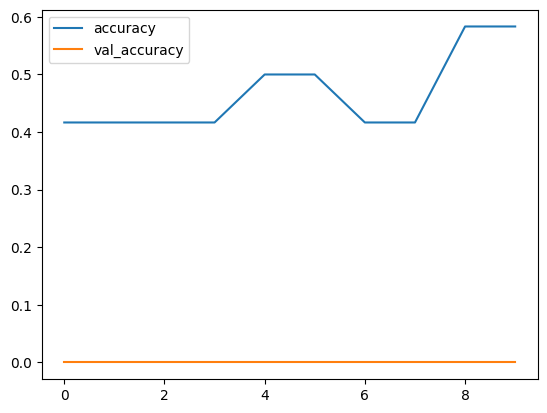

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

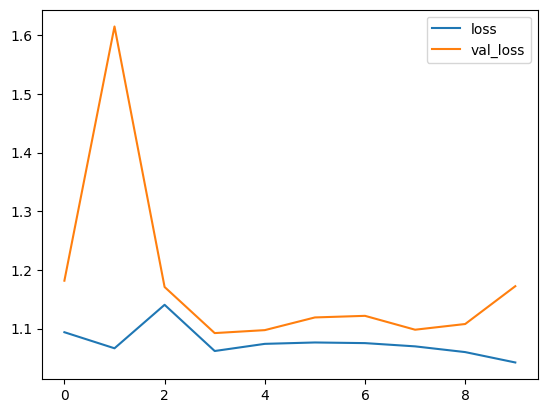

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Building Residual Network of ResNet

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization
from keras.layers import ReLU, Add, GlobalAveragePooling2D, Dense,MaxPooling2D


In [17]:
def res_block(input_shape, filters, strides=1):
    #
    shortcut = input_shape

    x = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters*4, (1,1), padding='same')(x)
    x = BatchNormalization()(x)
    # Skip connection
    if strides !=1 or shortcut.shape[-1]!= filters*4:
        shortcut = Conv2D(filters*4, (1,1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

Let's break down the lines of code for the residual block without the skip connection:

```python
def res_block(input_shape, filters, strides=1):
    # Save the input shape as the shortcut (identity) connection
    shortcut = input_shape

    # First convolution block
    x = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution block
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Third convolution block (expansion)
    x = Conv2D(filters*4, (1,1), padding='same')(x)
    x = BatchNormalization()(x)

    # Skip connection
    if strides != 1 or shortcut.shape[-1] != filters*4:
        shortcut = Conv2D(filters*4, (1,1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x
```

### Explanation:

1. **Save Input Shape as Shortcut Connection:**
   - `shortcut = input_shape`: This line saves the input tensor as the shortcut connection. The shortcut connection is used to add the original input to the main path later in the code.

2. **First Convolution Block (`x = Conv2D(filters, (1,1), strides=1, padding='same')(input_shape)`):**
   - This is a 1x1 convolution applied to the input shape.
   - Batch normalization and ReLU activation functions are applied to the output.

3. **Second Convolution Block (`x = Conv2D(filters, (3,3), padding='same')(x)`):**
   - This is a 3x3 convolution applied to the output of the first convolution block.
   - Batch normalization and ReLU activation functions are applied to the output.

4. **Third Convolution Block (Expansion, `x = Conv2D(filters*4, (1,1), padding='same')(x)`):**
   - This is a 1x1 convolution applied to the output of the second convolution block, intended for expansion (increasing the number of filters by a factor of 4).
   - Batch normalization is applied to the output.

5. **Skip Connection:**
   - `if strides != 1 or shortcut.shape[-1] != filters*4:`: This condition checks if the strides are not equal to 1 or if the number of channels in the shortcut does not match the expected number of channels after the third convolution block.
   - If the condition is true, a 1x1 convolution is applied to the shortcut to match the dimensions.
   - Batch normalization is applied to the shortcut.

6. **Add Shortcut to Main Path (`x = Add()([x, shortcut])`):**
   - The shortcut connection is added to the main path, facilitating the skip connection.
   - The combined result is passed through a ReLU activation function.

7. **Return (`return x`):**
   - The final output tensor is returned from the function.

In summary, this residual block applies three convolutional blocks to the input tensor and introduces a skip connection to facilitate the flow of gradients during training. The skip connection helps address the vanishing gradient problem in deep neural networks.




- Let's break down the lines of code that involve the skip connection in a residual block:

```python
# Skip connection
if strides != 1 or shortcut.shape[-1] != filters * 4:
    shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)
    shortcut = BatchNormalization()(shortcut)
# Add the shortcut to the main path
x = Add()([x, shortcut])
x = ReLU()(x)
```

### Explanation:

1. **Skip Connection Check (`if strides != 1 or shortcut.shape[-1] != filters * 4`):**
   - This line checks whether a skip connection (also known as a shortcut connection) is needed. A skip connection allows the gradient to flow more easily during training, mitigating the vanishing gradient problem.
   - The condition checks two things:
     - `strides != 1`: This condition checks if the convolutional block is downsampling the spatial dimensions. If `strides` is not equal to 1, it means the block is performing downsampling.
     - `shortcut.shape[-1] != filters * 4`: This checks if the number of channels (the last dimension of the shape) in the shortcut connection is not equal to four times the number of filters in the current block. If they are not equal, it means the shortcut needs to be adjusted to match the dimensions of the main path.

2. **Shortcut Adjustment (`shortcut = Conv2D(filters * 4, (1, 1), strides=strides, padding='same')(shortcut)`):**
   - If the skip connection check is True, this line adjusts the shortcut connection by applying a 1x1 convolution with `filters * 4` filters. This convolution is applied with the same strides as the main path convolution (controlled by the `strides` parameter).
   - The 1x1 convolution is used to adjust the number of channels in the shortcut to match the dimensions of the main path.

3. **Batch Normalization on Shortcut (`shortcut = BatchNormalization()(shortcut)`):**
   - After adjusting the shortcut, batch normalization is applied to the shortcut. Batch normalization helps stabilize and accelerate training by normalizing the input to a layer.

4. **Add the Shortcut to the Main Path (`x = Add()([x, shortcut])`):**
   - The adjusted shortcut is added to the output of the main path. This is the essence of the skip connection, where the original input (shortcut) is added to the transformed input of the main path. This helps in the flow of gradients during backpropagation.

5. **ReLU Activation (`x = ReLU()(x)`):**
   - After adding the shortcut, a Rectified Linear Unit (ReLU) activation is applied to the combined output. ReLU introduces non-linearity to the model by zeroing out negative values.

In summary, this block of code implements a residual block with a skip connection. The skip connection is adjusted based on the conditions specified, and the adjusted shortcut is added to the main path before applying a ReLU activation. This structure allows for the training of deeper networks more effectively by addressing the vanishing gradient problem.

In [18]:
input_shape = Input(shape=(128,128,3))

# Build a simple ResNet with two residual blocks
x = Conv2D(64, (7,7), strides=2, padding='same')(input_shape)
x = BatchNormalization()(x)
x = ReLU()(x)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=64, strides=1)
x = res_block(x, filters=64, strides=1)
x = MaxPooling2D(2,2)(x)
x = res_block(x, filters=128, strides=1)
x = res_block(x, filters=128, strides=1)
x = MaxPooling2D(2,2)(x)
x = GlobalAveragePooling2D()(x)
output = Dense(3, activation='softmax')(x)

In [19]:
model_2 = Model(inputs=input_shape, outputs=output)

In [20]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d_24[0][0]']              
 alization)                                                                                       
                                                                                            

In [21]:
# Compile the model
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model_2.fit(x_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.7288 - accuracy: 0.3333 - val_loss: 1.1203 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 90ms/step - loss: 0.2916 - accuracy: 0.8333 - val_loss: 1.1159 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 80ms/step - loss: 0.1291 - accuracy: 0.9167 - val_loss: 1.1442 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 80ms/step - loss: 0.0387 - accuracy: 1.0000 - val_loss: 1.1386 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 80ms/step - loss: 0.0465 - accuracy: 1.0000 - val_loss: 1.1223 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 71ms/step - loss: 0.0144 - accuracy: 1.0000 - val_loss: 1.1138 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 70ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.1141 - val_accuracy: 0.0000e+00
E

In [23]:
# Evaluate the model on the test set
test_loss, test_acc = model_1.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

1/1 [==============================] - 0s 50ms/step - loss: 1.0785 - accuracy: 0.5625
Test accuracy: 0.5625
Test loss: 1.0785197019577026


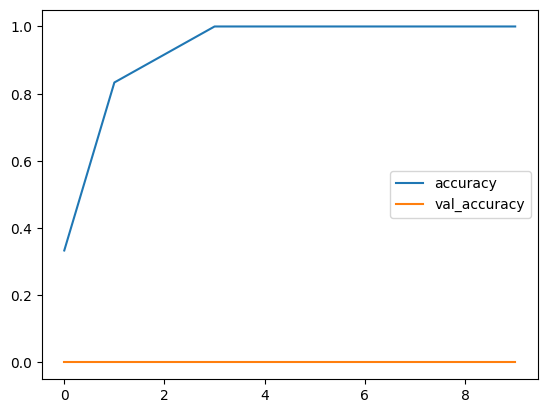

In [24]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

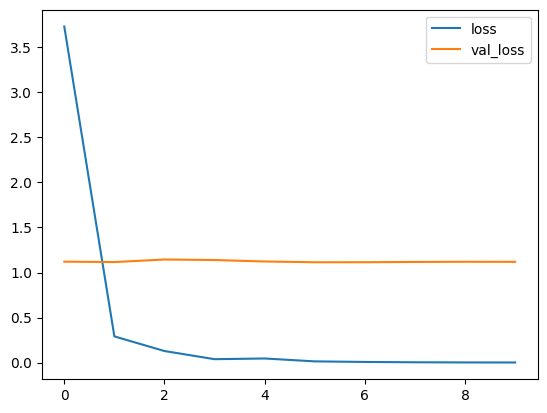

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# Combine the models into Creating the Ensemble Model

Let's break down the lines of code for creating the ensemble model:

```python
# Concatenate the outputs of the two models
concatenated_output = concatenate([model_1.output, model_2.output])

# Apply dense layers to the concatenated output
x = Dense(100, activation='relu')(concatenated_output)
x = Dense(50, activation='relu')(x)

# Create the final ensemble model output layer
ensemble_model = Dense(3, activation='relu')(x)

# Build the ensemble model
model = Model(inputs=[model_1.input, model_2.input], outputs=ensemble_model)
```

### Explanation:

1. **Concatenate Model Outputs (`concatenate([model_1.output, model_2.output])`):**
   - `concatenate` is a function that concatenates tensors along a specified axis. Here, it concatenates the outputs of `model_1` and `model_2` along the last axis (`axis=-1`).
   - `model_1.output` and `model_2.output` are the final output tensors of the respective models.

2. **Dense Layers Applied to Concatenated Output (`x = Dense(100, activation='relu')(concatenated_output)` and `x = Dense(50, activation='relu')(x)`):**
   - Two dense layers are applied successively to the concatenated output tensor (`concatenated_output`).
   - The first dense layer has 100 units with a ReLU activation function.
   - The second dense layer has 50 units with a ReLU activation function.
   - These dense layers introduce non-linear transformations to the concatenated features, allowing the model to learn complex representations.

3. **Create Final Ensemble Model Output Layer (`ensemble_model = Dense(3, activation='relu')(x)`):**
   - Another dense layer is added to produce the final ensemble model output.
   - It has 3 units, representing the number of classes in the classification problem.
   - The ReLU activation function is applied to the output.

4. **Build the Ensemble Model (`model = Model(inputs=[model_1.input, model_2.input], outputs=ensemble_model)`):**
   - The `Model` class is used to create the ensemble model.
   - The inputs to the model are the input layers of `model_1` and `model_2`.
   - The output is the `ensemble_model` created by stacking dense layers on the concatenated output.

In summary, this code creates an ensemble model by concatenating the outputs of two existing models (`model_1` and `model_2`). Dense layers are then applied to the concatenated output to introduce non-linear transformations, and the final output layer is created for classification. The resulting ensemble model is built using the Keras `Model` class.

In [26]:
concatenated_output= concatenate([model_1.output, model_2.output])

In [27]:
x = Dense(100, activation='relu')(concatenated_output)
x = Dense(50, activation='relu')(x)
ensemble_model= Dense(3, activation='relu')(x)


In [28]:
#Build the ensemble model
model = Model(inputs=[model_1.input, model_2.input] , outputs= ensemble_model)

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Display the ensemble model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 64, 64, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['conv2d_24[0][0]']              
 alization)                                                                                       
                                                                                            

In [31]:
# Train the ensemble model
history = model.fit([x_train, x_train], y_train, epochs=10, validation_split=0.2)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.9950 - accuracy: 0.4167 - val_loss: 4.3189 - val_accuracy: 0.7500
Epoch 2/10
1/1 [==============================] - 0s 122ms/step - loss: 2.0942 - accuracy: 0.4167 - val_loss: 4.2759 - val_accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 0s 122ms/step - loss: 0.9828 - accuracy: 0.5000 - val_loss: 4.3532 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 0s 121ms/step - loss: 0.8203 - accuracy: 0.5833 - val_loss: 4.3980 - val_accuracy: 0.7500
Epoch 5/10
1/1 [==============================] - 0s 121ms/step - loss: 0.6948 - accuracy: 0.5833 - val_loss: 4.4692 - val_accuracy: 0.7500
Epoch 6/10
1/1 [==============================] - 0s 120ms/step - loss: 0.6732 - accuracy: 0.5833 - val_loss: 4.5519 - val_accuracy: 0.2500
Epoch 7/10
1/1 [==============================] - 0s 140ms/step - loss: 0.6815 - accuracy: 0.5833 - val_loss: 4.5871 - val_accuracy: 0.0000e+00
Epoch 8/10
1/1 [===

In [32]:
# Evaluate the ensemble model on the test set
test_loss_ensemble, test_acc_ensemble = model.evaluate([x_test,x_test], y_test)
print("Ensemble Test accuracy:", test_acc_ensemble)
print("Ensemble Test loss:", test_loss_ensemble)

1/1 [==============================] - 0s 332ms/step - loss: 5.5172 - accuracy: 0.3125
Ensemble Test accuracy: 0.3125
Ensemble Test loss: 5.517234802246094


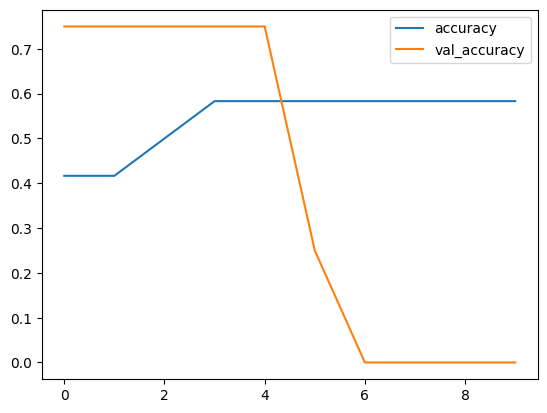

In [33]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

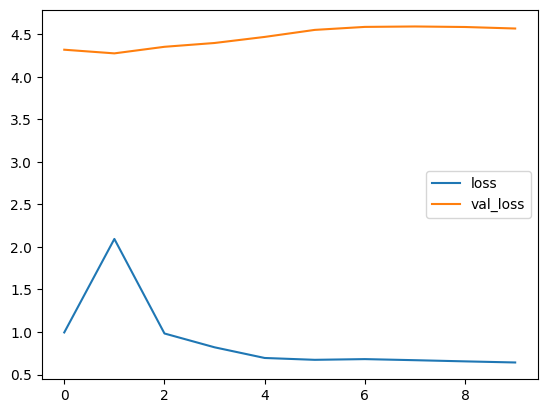

In [34]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [35]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model_1

In [36]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()